In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from dask import dataframe as dd
from distributed import Client

In [2]:
client = Client()
client

/home/dave/miniforge3/envs/lsst-uk/lib/python3.13/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35049 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33957' processes=4 threads=12, memory=7.43 GiB>

In [3]:
platforms = ['cirrus', 'somerville', 'csd3dtn', 'stfc']
compressions = ['Comp', 'NoComp']
platform = platforms[2]
compression = compressions[0]
workerss = [8, 16, 32, 48]
workers = workerss[0]
threadss = [1, 2]
threads = threadss[1]
base_paths = []
for p in platforms:
    for c in compressions:
        for w in workerss:
            for t in threadss:
                base_path = f'{os.environ["HOME"]}/testing_by_platform/{p}/{c}_{w}-{t}'
                if os.path.exists(base_path) and os.path.isdir(base_path):
                    base_paths.append(base_path)

In [4]:
paths = []
for bp in base_paths:
    p = glob.glob(bp+'/*-lsst-backup.csv')[0]
    print(p)
    paths.append(p)

/home/dave/testing_by_platform/cirrus/Comp_8-2/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/cirrus/Comp_16-1/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/cirrus/NoComp_8-2/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/cirrus/NoComp_16-1/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/somerville/Comp_8-2/dummy_data-data-lsst-backup.csv
/home/dave/testing_by_platform/somerville/Comp_16-1/dummy_data-data-lsst-backup.csv
/home/dave/testing_by_platform/somerville/NoComp_8-2/dummy_data-data-lsst-backup.csv
/home/dave/testing_by_platform/somerville/NoComp_16-1/dummy_data-data-lsst-backup.csv
/home/dave/testing_by_platform/csd3dtn/Comp_8-2/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/csd3dtn/Comp_16-1/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/csd3dtn/Comp_48-1/test_by_platform-lsst-backup.csv
/home/dave/testing_by_platform/csd3dtn/NoComp_8-2/test_by_platform-lsst-backup.csv
/home/da

In [5]:
df = dd.read_csv(paths).drop(columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM'])
df

Dask DataFrame Structure:
               LOCAL_PATH FILE_SIZE BUCKET_NAME ZIP_CONTENTS FILES_PER_ZIP UPLOAD_TIME UPLOAD_START UPLOAD_END
npartitions=19                                                                                                
                   string     int64      string       string       float64     float64       string     string
                      ...       ...         ...          ...           ...         ...          ...        ...
...                   ...       ...         ...          ...           ...         ...          ...        ...
                      ...       ...         ...          ...           ...         ...          ...        ...
                      ...       ...         ...          ...           ...         ...          ...        ...
Dask Name: drop_by_shallow_copy, 3 expressions
Expr=Drop(frame=ArrowStringConversion(frame=FromMapProjectable(7ee8a00)), columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM'])

In [6]:
df.sort_values(by='UPLOAD_START')

Dask DataFrame Structure:
               LOCAL_PATH FILE_SIZE BUCKET_NAME ZIP_CONTENTS FILES_PER_ZIP UPLOAD_TIME UPLOAD_START UPLOAD_END
npartitions=19                                                                                                
                   string     int64      string       string       float64     float64       string     string
                      ...       ...         ...          ...           ...         ...          ...        ...
...                   ...       ...         ...          ...           ...         ...          ...        ...
                      ...       ...         ...          ...           ...         ...          ...        ...
                      ...       ...         ...          ...           ...         ...          ...        ...
Dask Name: sortvalues, 4 expressions
Expr=SortValues(frame=Drop(frame=ArrowStringConversion(frame=FromMapProjectable(7ee8a00)), columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM']), by=['UPLOAD_START'], options={})

In [7]:
# testing computing a single partition
# df_pd = df.partitions[0].compute()
# df_pd['SITE'] = df_pd['BUCKET_NAME'].apply(lambda x: x.split('_')[1])
# df_pd

In [8]:
def extract_site(row):
    print(row)
    return row['BUCKET_NAME'].split('_')[1]

In [9]:
# symlinks_ddf['target'] = symlinks_ddf.map_partitions(
#     lambda partition: partition.apply(
#         get_target_or_none,
#         axis=1,
#     ),
#     meta=('target', 'str')
# )


df['SITE'] = df.map_partitions(
    lambda p: p.apply(
        extract_site,
        axis=1,
    ),
    meta=('SITE', 'object')
)

In [10]:
df2 = df.compute()

LOCAL_PATH                                          collated_0.zip
FILE_SIZE                                               1000788557
BUCKET_NAME      Somerville-RAL-Transfer-Tests_stfc_std_NoComp_...
ZIP_CONTENTS     dummy_data/.lsst-backup-tmp/collated_100_40084...
FILES_PER_ZIP                                                  3.0
UPLOAD_TIME                                               6.872138
UPLOAD_START                            2025-10-21 14:28:49.169182
UPLOAD_END                              2025-10-21 14:28:56.041320
Name: 0, dtype: object
LOCAL_PATH                                          collated_3.zip
FILE_SIZE                                               1034952851
BUCKET_NAME          Somerville-RAL-Transfer-Tests_std_NoComp_16-1
ZIP_CONTENTS     dummy_data/data/s/33/32/32.f|dummy_data/data/s...
FILES_PER_ZIP                                                 43.0
UPLOAD_TIME                                               9.748563
UPLOAD_START                           

In [11]:
df2

LOCAL_PATH  FILE_SIZE  \
0                          collated_4.zip  630387352   
1                          collated_6.zip  783527151   
2                          collated_0.zip  884223468   
3                          collated_3.zip  914638264   
4                          collated_2.zip  946106140   
..                                    ...        ...   
329  /home/ubuntu/dummy_data/l/56/10/10.f  618659840   
330    /home/ubuntu/dummy_data/l/42/5/5.f  946864128   
331    /home/ubuntu/dummy_data/l/56/2/2.f  801112064   
332    /home/ubuntu/dummy_data/l/60/3/3.f  964689920   
333    /home/ubuntu/dummy_data/l/56/5/5.f  932184064   

                                           BUCKET_NAME  \
0    Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
1    Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
2    Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
3    Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
4    Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
..                                                 ...   
329  Somerville-RAL-Transfer-Tests_stfc_std_NoComp_...   
330  Somerville-RAL-Transfer-Tests_stfc_std_NoComp_...   
331  Somerville-RAL-Transfer-Tests_stfc_std_NoComp_...   
332  Somerville-RAL-Transfer-Tests_stfc_std_NoComp_...   
333  Somerville-RAL-Transfer-Tests_stfc_std_NoComp_...   

                                          ZIP_CONTENTS  FILES_PER_ZIP  \
0    test_by_platform/l/48/9/9.f|test_by_platform/l...            5.0   
1    test_by_platform/l/53/8/8.f|test_by_platform/l...           10.0   
2    test_by_platform/l/41/8/manifest.txt|test_by_p...           21.0   
3    test_by_platform/l/59/5/5.f|test_by_platform/l...            6.0   
4    test_by_platform/l/59/9/9.f|test_by_platform/l...           11.0   
..                                                 ...            ...   
329                                               <NA>            NaN   
330                                               <NA>            NaN   
331                                               <NA>            NaN   
332                                               <NA>            NaN   
333                                               <NA>            NaN   

     UPLOAD_TIME                UPLOAD_START                  UPLOAD_END  \
0       5.663316  2025-10-22 21:12:43.037624  2025-10-22 21:12:48.700940   
1       5.821956  2025-10-22 21:12:49.222554  2025-10-22 21:12:55.044510   
2       6.644899  2025-10-22 21:12:54.293436  2025-10-22 21:13:00.938335   
3       6.659704  2025-10-22 21:12:54.891007  2025-10-22 21:13:01.550711   
4       8.585220  2025-10-22 21:12:55.985008  2025-10-22 21:13:04.570228   
..           ...                         ...                         ...   
329     6.193258  2025-10-21 16:01:58.124303  2025-10-21 16:02:04.317561   
330     9.277174  2025-10-21 16:01:56.316703  2025-10-21 16:02:05.593877   
331     7.687909  2025-10-21 16:01:58.438644  2025-10-21 16:02:06.126553   
332    10.414162  2025-10-21 16:01:55.879082  2025-10-21 16:02:06.293244   
333     9.704572  2025-10-21 16:01:59.565474  2025-10-21 16:02:09.270046   

       SITE  
0    cirrus  
1    cirrus  
2    cirrus  
3    cirrus  
4    cirrus  
..      ...  
329    stfc  
330    stfc  
331    stfc  
332    stfc  
333    stfc  

[6493 rows x 9 columns]

In [14]:
df['FILES_PER_ZIP'] = df['FILES_PER_ZIP'].fillna(0).astype(int)
df

Dask DataFrame Structure:
               LOCAL_PATH FILE_SIZE BUCKET_NAME ZIP_CONTENTS FILES_PER_ZIP UPLOAD_TIME UPLOAD_START UPLOAD_END    SITE
npartitions=19                                                                                                        
                   string     int64      string       string         int64     float64       string     string  object
                      ...       ...         ...          ...           ...         ...          ...        ...     ...
...                   ...       ...         ...          ...           ...         ...          ...        ...     ...
                      ...       ...         ...          ...           ...         ...          ...        ...     ...
                      ...       ...         ...          ...           ...         ...          ...        ...     ...
Dask Name: assign, 10 expressions
Expr=Assign(frame=Assign(frame=Drop(frame=ArrowStringConversion(frame=FromMapProjectable(7ee8a00)), columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM'])))

In [16]:
def object_to_datetime(row, col_name):
    return pd.to_datetime(row[col_name], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [17]:
df['FILES_PER_ZIP'] = df['FILES_PER_ZIP'].astype('Int64')
df['FILE_SIZE'] = df['FILE_SIZE'].astype('Int64')
df

Dask DataFrame Structure:
               LOCAL_PATH FILE_SIZE BUCKET_NAME ZIP_CONTENTS FILES_PER_ZIP UPLOAD_TIME UPLOAD_START UPLOAD_END    SITE
npartitions=19                                                                                                        
                   string     Int64      string       string         Int64     float64       string     string  object
                      ...       ...         ...          ...           ...         ...          ...        ...     ...
...                   ...       ...         ...          ...           ...         ...          ...        ...     ...
                      ...       ...         ...          ...           ...         ...          ...        ...     ...
                      ...       ...         ...          ...           ...         ...          ...        ...     ...
Dask Name: assign, 19 expressions
Expr=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Drop(frame=ArrowStringConversion(frame=FromMapProjectable(7ee8a00)), columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM']))))))

In [18]:
df['UPLOAD_END'] = df.map_partitions(lambda p: p.apply(object_to_datetime, col_name='UPLOAD_END', axis=1), meta=('UPLOAD_END', 'datetime64[ns]'))
df['UPLOAD_START'] = df.map_partitions(lambda p: p.apply(object_to_datetime, col_name='UPLOAD_START', axis=1), meta=('UPLOAD_START', 'datetime64[ns]'))
df = df.dropna(subset=['UPLOAD_END', 'UPLOAD_START', 'FILE_SIZE'])
df

Dask DataFrame Structure:
               LOCAL_PATH FILE_SIZE BUCKET_NAME ZIP_CONTENTS FILES_PER_ZIP UPLOAD_TIME    UPLOAD_START      UPLOAD_END    SITE
npartitions=19                                                                                                                
                   string     Int64      string       string         Int64     float64  datetime64[ns]  datetime64[ns]  object
                      ...       ...         ...          ...           ...         ...             ...             ...     ...
...                   ...       ...         ...          ...           ...         ...             ...             ...     ...
                      ...       ...         ...          ...           ...         ...             ...             ...     ...
                      ...       ...         ...          ...           ...         ...             ...             ...     ...
Dask Name: dropna, 24 expressions
Expr=DropnaFrame(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Drop(frame=ArrowStringConversion(frame=FromMapProjectable(7ee8a00)), columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM'])))))))), subset=['UPLOAD_END', 'UPLOAD_START', 'FILE_SIZE'])

In [19]:
def extract_overlaps(partition):
    return partition['UPLOAD_END'].shift(1) > partition['UPLOAD_START']

In [20]:
df['OVERLAP'] = df.map_partitions(extract_overlaps, meta=('OVERLAP', 'bool'))
df

Dask DataFrame Structure:
               LOCAL_PATH FILE_SIZE BUCKET_NAME ZIP_CONTENTS FILES_PER_ZIP UPLOAD_TIME    UPLOAD_START      UPLOAD_END    SITE OVERLAP
npartitions=19                                                                                                                        
                   string     Int64      string       string         Int64     float64  datetime64[ns]  datetime64[ns]  object    bool
                      ...       ...         ...          ...           ...         ...             ...             ...     ...     ...
...                   ...       ...         ...          ...           ...         ...             ...             ...     ...     ...
                      ...       ...         ...          ...           ...         ...             ...             ...     ...     ...
                      ...       ...         ...          ...           ...         ...             ...             ...     ...     ...
Dask Name: assign, 26 expressions
Expr=Assign(frame=DropnaFrame(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Drop(frame=ArrowStringConversion(frame=FromMapProjectable(7ee8a00)), columns=['LOCAL_FOLDER', 'DESTINATION_KEY', 'CHECKSUM'])))))))), subset=['UPLOAD_END', 'UPLOAD_START', 'FILE_SIZE']))

In [22]:
df[df['OVERLAP'] == True].compute()

TypeError: extract_site() got an unexpected keyword argument 'axis'

In [57]:
df = df.drop(columns=['ZIP_CONTENTS'])

In [58]:
print(f'Instances of overlap: {df["OVERLAP"].sum()} vs instanses of no overlap: {(~df["OVERLAP"]).sum()}')

Instances of overlap: 281 vs instanses of no overlap: 65


In [59]:
df['TYPE'] = df['LOCAL_PATH'].apply(lambda x: 'zip' if x.endswith('.zip') else 'file')
df.drop(columns=['LOCAL_PATH'], inplace=True)
df

FILE_SIZE                                        BUCKET_NAME  \
0     630387352  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
1     783527151  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
2     884223468  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
3     914638264  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
4     946106140  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
..          ...                                                ...   
341   875829116  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
342   660604467  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
343   999295513  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
344   953157956  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
345  1049628131  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   

     FILES_PER_ZIP  UPLOAD_TIME               UPLOAD_START  \
0                5     5.663316 2025-10-22 21:12:43.037624   
1               10     5.821956 2025-10-22 21:12:49.222554   
2               21     6.644899 2025-10-22 21:12:54.293436   
3                6     6.659704 2025-10-22 21:12:54.891007   
4               11     8.585220 2025-10-22 21:12:55.985008   
..             ...          ...                        ...   
341              0     8.750939 2025-10-22 21:45:10.306652   
342              0     6.409184 2025-10-22 21:45:14.688120   
343              0     9.644095 2025-10-22 21:45:11.907669   
344              0    19.499052 2025-10-22 21:45:05.844277   
345              0    19.189353 2025-10-22 21:45:14.876560   

                    UPLOAD_END  OVERLAP TYPE  
0   2025-10-22 21:12:48.700940    False  zip  
1   2025-10-22 21:12:55.044510    False  zip  
2   2025-10-22 21:13:00.938335     True  zip  
3   2025-10-22 21:13:01.550711     True  zip  
4   2025-10-22 21:13:04.570228     True  zip  
..                         ...      ...  ...  
341 2025-10-22 21:45:19.057591     True  zip  
342 2025-10-22 21:45:21.097304     True  zip  
343 2025-10-22 21:45:21.551764     True  zip  
344 2025-10-22 21:45:25.343329     True  zip  
345 2025-10-22 21:45:34.065913     True  zip  

[346 rows x 8 columns]

In [60]:
df['COMPRESSION_USED'] = df.apply(lambda row: True if compression == 'Comp' and row['TYPE'] == 'zip' else False, axis=1)
df

FILE_SIZE                                        BUCKET_NAME  \
0     630387352  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
1     783527151  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
2     884223468  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
3     914638264  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
4     946106140  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
..          ...                                                ...   
341   875829116  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
342   660604467  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
343   999295513  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
344   953157956  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
345  1049628131  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   

     FILES_PER_ZIP  UPLOAD_TIME               UPLOAD_START  \
0                5     5.663316 2025-10-22 21:12:43.037624   
1               10     5.821956 2025-10-22 21:12:49.222554   
2               21     6.644899 2025-10-22 21:12:54.293436   
3                6     6.659704 2025-10-22 21:12:54.891007   
4               11     8.585220 2025-10-22 21:12:55.985008   
..             ...          ...                        ...   
341              0     8.750939 2025-10-22 21:45:10.306652   
342              0     6.409184 2025-10-22 21:45:14.688120   
343              0     9.644095 2025-10-22 21:45:11.907669   
344              0    19.499052 2025-10-22 21:45:05.844277   
345              0    19.189353 2025-10-22 21:45:14.876560   

                    UPLOAD_END  OVERLAP TYPE  COMPRESSION_USED  
0   2025-10-22 21:12:48.700940    False  zip              True  
1   2025-10-22 21:12:55.044510    False  zip              True  
2   2025-10-22 21:13:00.938335     True  zip              True  
3   2025-10-22 21:13:01.550711     True  zip              True  
4   2025-10-22 21:13:04.570228     True  zip              True  
..                         ...      ...  ...               ...  
341 2025-10-22 21:45:19.057591     True  zip              True  
342 2025-10-22 21:45:21.097304     True  zip              True  
343 2025-10-22 21:45:21.551764     True  zip              True  
344 2025-10-22 21:45:25.343329     True  zip              True  
345 2025-10-22 21:45:34.065913     True  zip              True  

[346 rows x 9 columns]

In [61]:
len(df[df['TYPE'] == 'zip']), len(df[df['TYPE'] == 'file'])

(247, 99)

In [62]:
df['FILE_SIZE'].sum() / 1024**3

np.float64(306.1069027604535)

In [63]:
zip_upload_time = df[df['TYPE'] == 'zip']['UPLOAD_TIME'].sum()
zip_upload_time

np.float64(3160.1796640000002)

In [64]:
print(f"Total upload time for zip files: {df[df['TYPE'] == 'zip']['UPLOAD_TIME'].sum():.0f} seconds")
print(f"Average upload time for zip files: {df[df['TYPE'] == 'zip']['UPLOAD_TIME'].mean():.2f} seconds")
print(f"Avergage number of files per zip: {df[df['TYPE'] == 'zip']['FILES_PER_ZIP'].mean():.2f}")
print(f"Total files in zips: {df[df['TYPE'] == 'zip']['FILES_PER_ZIP'].sum():.0f}")
print(f"Average upload time per file in zips: {zip_upload_time / df[df['TYPE'] == 'zip']['FILES_PER_ZIP'].sum():.2f} seconds")
print(f"Total upload time for file uploads: {df[df['TYPE'] == 'file']['UPLOAD_TIME'].sum():.0f} seconds")
print(f"Average upload time for file uploads: {df[df['TYPE'] == 'file']['UPLOAD_TIME'].mean():.2f} seconds")
print(f"Total upload time: {df['UPLOAD_TIME'].sum():.0f} seconds")
print(f"Average upload time: {df['UPLOAD_TIME'].mean():.2f} seconds")

Total upload time for zip files: 3160 seconds
Average upload time for zip files: 12.79 seconds
Avergage number of files per zip: 33.61
Total files in zips: 8301
Average upload time per file in zips: 0.38 seconds
Total upload time for file uploads: 1080 seconds
Average upload time for file uploads: 10.91 seconds
Total upload time: 4240 seconds
Average upload time: 12.25 seconds


In [65]:
zip_total_size = df[df['TYPE'] == 'zip']['FILE_SIZE'].sum()
zip_total_size / (1024 * 1024 * 1024)

np.float64(232.66256682295352)

In [66]:
file_total_size = df[df['TYPE'] == 'file']['FILE_SIZE'].sum()
file_total_size / (1024 * 1024 * 1024)

np.float64(73.4443359375)

In [67]:
print(f"Zip file size stats (MB):")
print(df[df['TYPE'] == 'zip']['FILE_SIZE'].describe() / (1024 * 1024))

Zip file size stats (MB):
count       0.000236
mean      964.560601
std        96.891717
min       183.057203
25%       967.300911
50%       993.308632
75%      1008.814113
max      1023.318987
Name: FILE_SIZE, dtype: Float64


In [68]:
print(f"File size stats (MB):")
print(df[df['TYPE'] == 'file']['FILE_SIZE'].describe() / (1024 * 1024))

File size stats (MB):
count      0.000094
mean     759.666667
std      138.635111
min           513.0
25%           636.0
50%           765.0
75%           885.5
max           995.0
Name: FILE_SIZE, dtype: Float64


In [69]:
df['TRANSFER_RATE'] = (df['FILE_SIZE'] * 8) / 1024**3 / df['UPLOAD_TIME']
print(f"Transfer rate stats (Gb/s):")
df['TRANSFER_RATE'].describe()

Transfer rate stats (Gb/s):


count       346.0
mean     0.691134
std      0.219186
min      0.111243
25%      0.530807
50%      0.761893
75%      0.835559
max      1.060509
Name: TRANSFER_RATE, dtype: Float64

/tmp/ipykernel_1728/1779115694.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['TYPE'] == 'zip'][df['COMPRESSION_USED']]['FILE_SIZE']/1024**2, bins=50, color='blue', alpha=0.7, edgecolor='black')


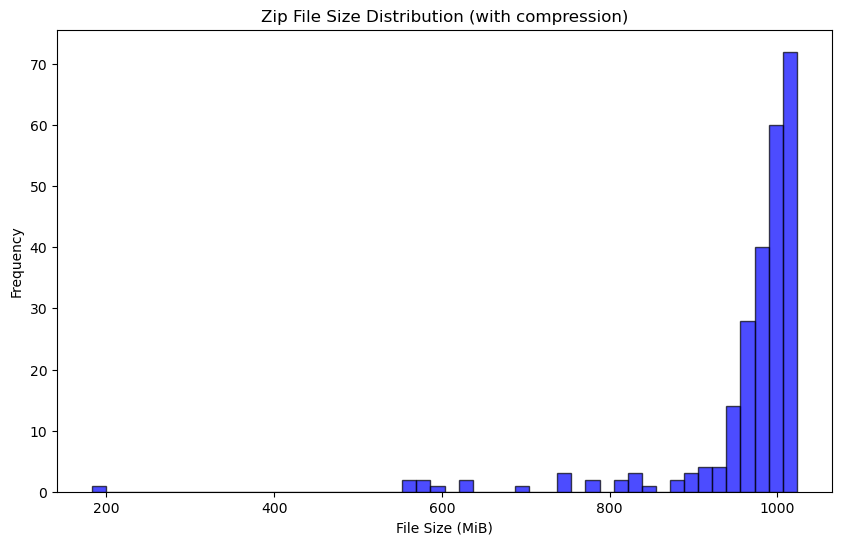

In [70]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'zip'][df['COMPRESSION_USED']]['FILE_SIZE']/1024**2, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Zip File Size Distribution (with compression)')
plt.xlabel('File Size (MiB)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_1728/3032775866.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['TYPE'] == 'zip'][~df['COMPRESSION_USED']]['FILE_SIZE']/1024**2, bins=50, color='orange', alpha=0.7, edgecolor='black')


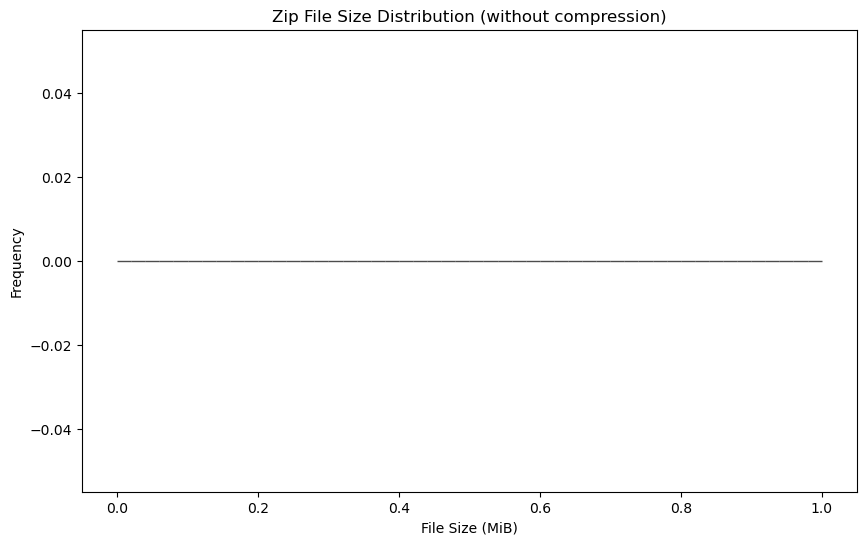

In [71]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'zip'][~df['COMPRESSION_USED']]['FILE_SIZE']/1024**2, bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title('Zip File Size Distribution (without compression)')
plt.xlabel('File Size (MiB)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

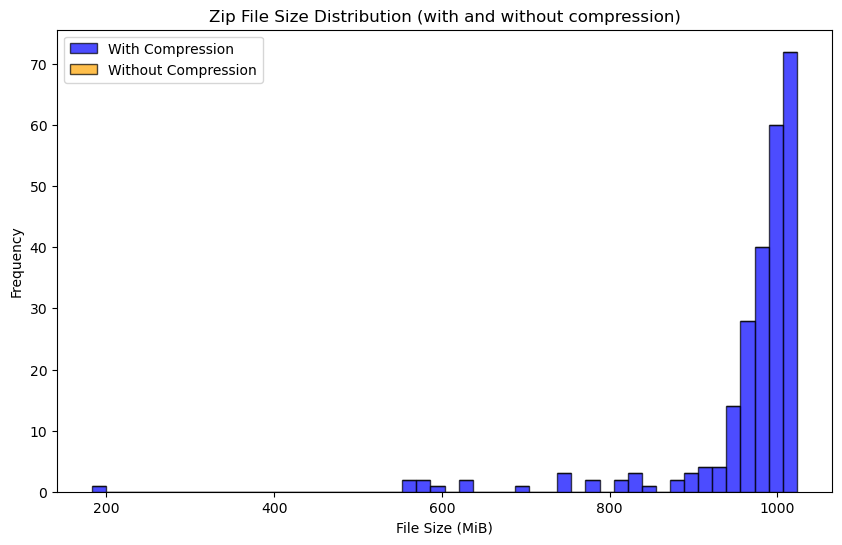

In [72]:
plt.figure(figsize=(10, 6))

# Prepare the data for the stacked histogram
comp_sizes = df[(df['TYPE'] == 'zip') & (df['COMPRESSION_USED'])]['FILE_SIZE'] / 1024**2
nocomp_sizes = df[(df['TYPE'] == 'zip') & (~df['COMPRESSION_USED'])]['FILE_SIZE'] / 1024**2

# Plot the stacked histogram
plt.hist([comp_sizes, nocomp_sizes], 
         bins=50, 
         color=['blue', 'orange'], 
         alpha=0.7, 
         edgecolor='black',
         stacked=True, 
         label=['With Compression', 'Without Compression'])

plt.title('Zip File Size Distribution (with and without compression)')
plt.xlabel('File Size (MiB)')
plt.ylabel('Frequency')
plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_1728/3329500516.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['TYPE'] == 'zip'][df['COMPRESSION_USED']]['TRANSFER_RATE'], bins=50, color='blue', alpha=0.7, edgecolor='black')


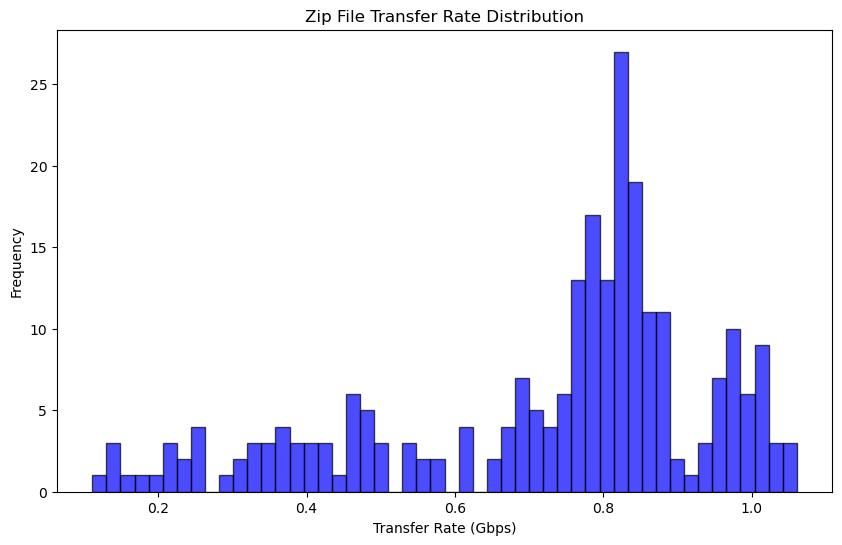

In [73]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'zip'][df['COMPRESSION_USED']]['TRANSFER_RATE'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Zip File Transfer Rate Distribution')
plt.xlabel('Transfer Rate (Gbps)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_1728/511990372.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(df[df['TYPE'] == 'zip'][~df['COMPRESSION_USED']]['TRANSFER_RATE'], bins=50, color='orange', alpha=0.7, edgecolor='black')


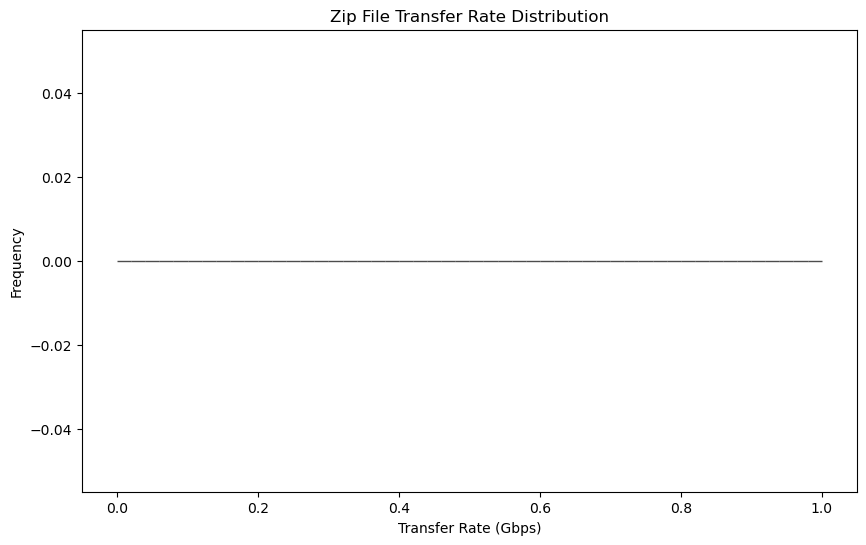

In [74]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'zip'][~df['COMPRESSION_USED']]['TRANSFER_RATE'], bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title('Zip File Transfer Rate Distribution')
plt.xlabel('Transfer Rate (Gbps)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

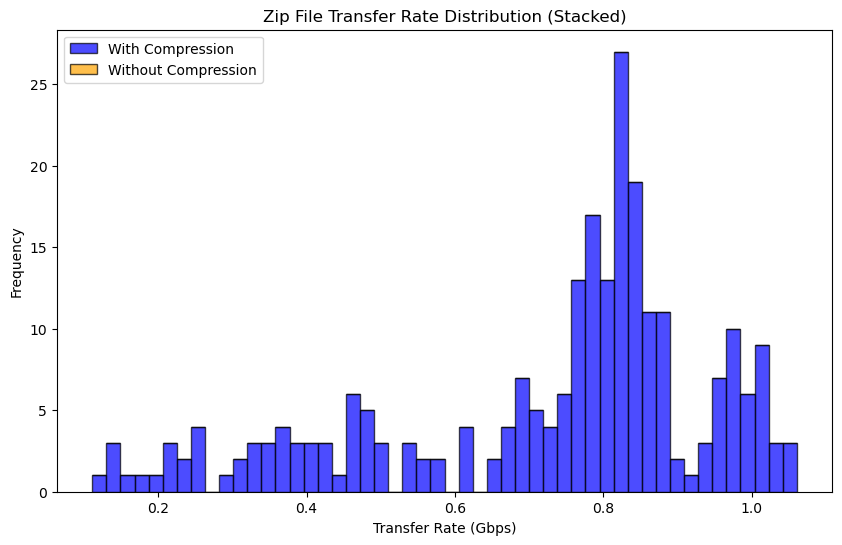

In [75]:
plt.figure(figsize=(10, 6))

# Prepare the data for the stacked histogram
comp_rates = df[(df['TYPE'] == 'zip') & (df['COMPRESSION_USED'])]['TRANSFER_RATE']
nocomp_rates = df[(df['TYPE'] == 'zip') & (~df['COMPRESSION_USED'])]['TRANSFER_RATE']

# Plot the stacked histogram
plt.hist([comp_rates, nocomp_rates], 
         bins=50, 
         color=['blue', 'orange'], 
         alpha=0.7, 
         edgecolor='black',
         stacked=True, 
         label=['With Compression', 'Without Compression'])

plt.title('Zip File Transfer Rate Distribution (Stacked)')
plt.xlabel('Transfer Rate (Gbps)')
plt.ylabel('Frequency')
plt.legend()
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

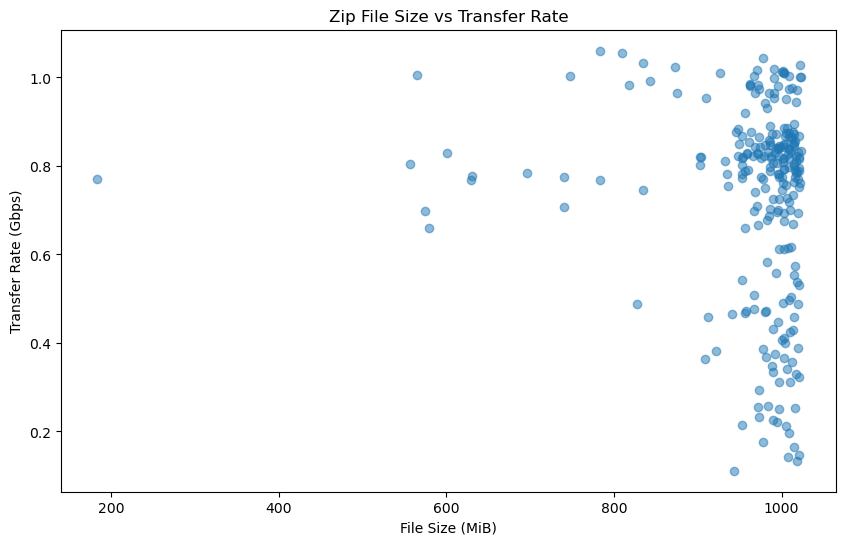

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(df[df['TYPE'] == 'zip']['FILE_SIZE'] / 1024**2, df[df['TYPE'] == 'zip']['TRANSFER_RATE'], alpha=0.5)
plt.title('Zip File Size vs Transfer Rate')
# plt.xlim(0,3000)
# plt.ylim(0, 15)
plt.xlabel('File Size (MiB)')
plt.ylabel('Transfer Rate (Gbps)')
plt.show()

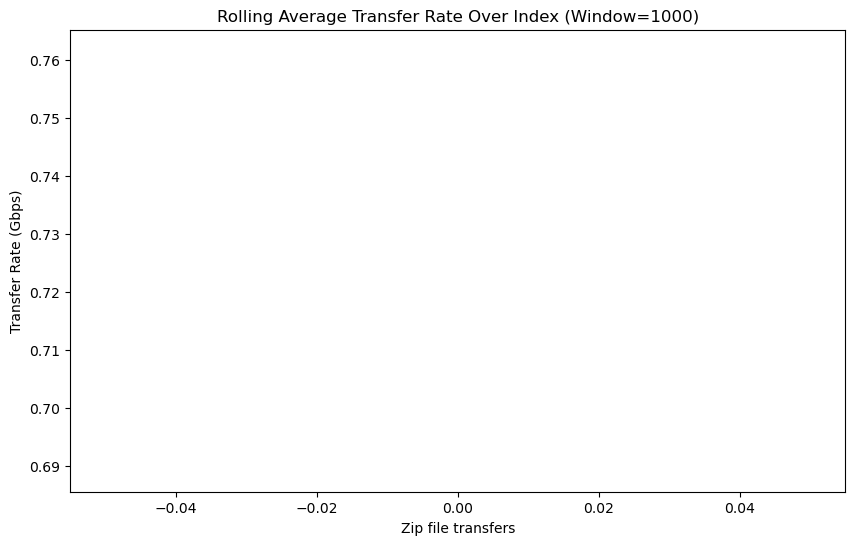

In [77]:
# Calculate the rolling average of the transfer rate over a window of 100
rolling_avg = df[df['TYPE'] == 'zip']['TRANSFER_RATE'].mean()

# Plotting the rolling average transfer rate over the index
plt.figure(figsize=(10, 6))
plt.plot(rolling_avg)
plt.title('Rolling Average Transfer Rate Over Index (Window=1000)')
# plt.xlim(0,3000)
# plt.ylim(0, 15)
plt.xlabel('Zip file transfers')
plt.ylabel('Transfer Rate (Gbps)')
plt.show()

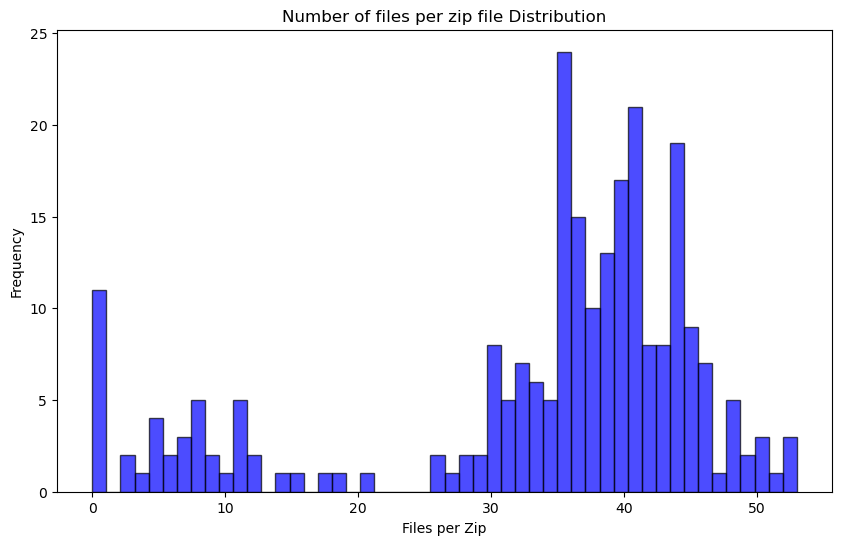

In [78]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'zip']['FILES_PER_ZIP'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Number of files per zip file Distribution')
plt.xlabel('Files per Zip')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

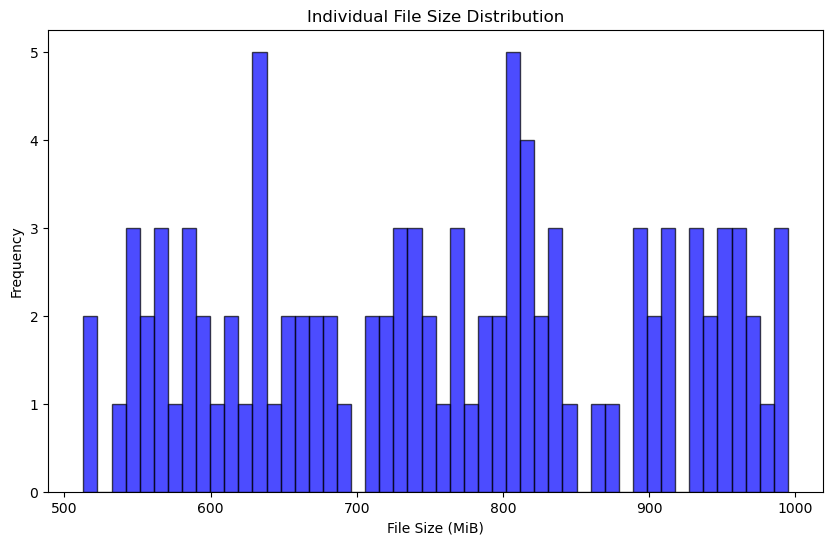

In [79]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'file']['FILE_SIZE']/1024**2, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Individual File Size Distribution')
plt.xlabel('File Size (MiB)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

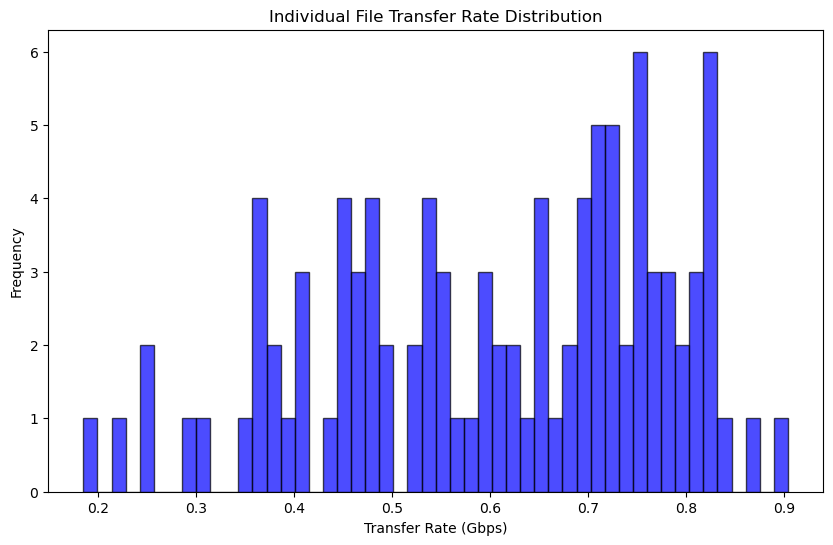

In [80]:
plt.figure(figsize=(10, 6))
plt.hist(df[df['TYPE'] == 'file']['TRANSFER_RATE'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Individual File Transfer Rate Distribution')
plt.xlabel('Transfer Rate (Gbps)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

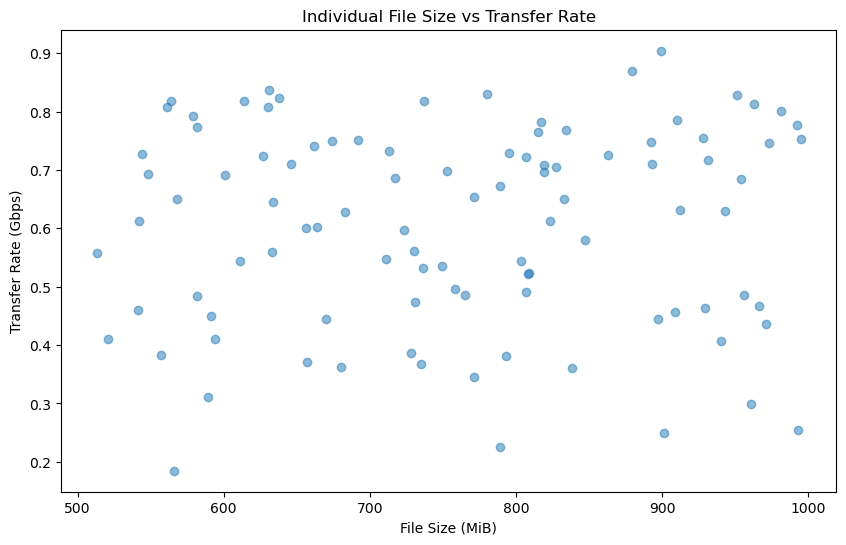

In [81]:
plt.figure(figsize=(10, 6))
plt.scatter(df[df['TYPE'] == 'file']['FILE_SIZE'] / 1024**2, df[df['TYPE'] == 'file']['TRANSFER_RATE'], alpha=0.5)
plt.title('Individual File Size vs Transfer Rate')
# plt.xlim(0,3000)
# plt.ylim(0, 15)
plt.xlabel('File Size (MiB)')
plt.ylabel('Transfer Rate (Gbps)')
plt.show()

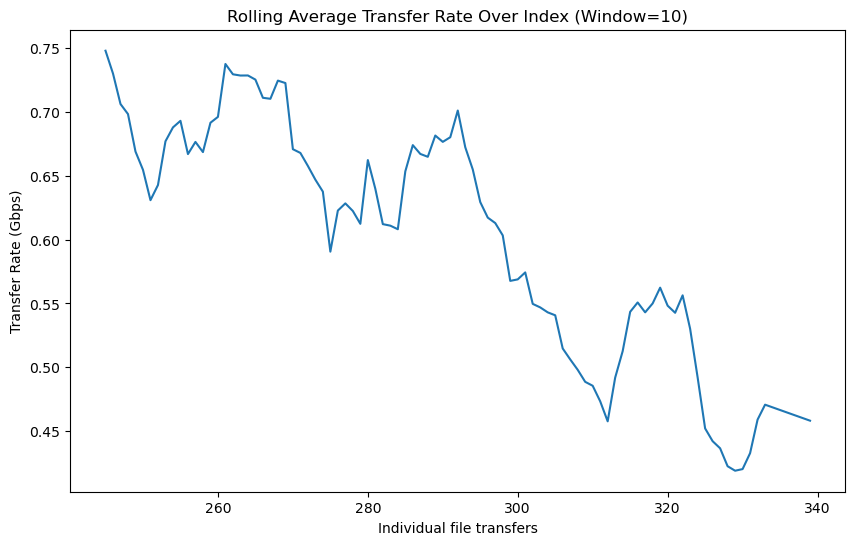

In [82]:
# Calculate the rolling average of the transfer rate over a window of 100
rolling_avg = df[df['TYPE'] == 'file']['TRANSFER_RATE'].rolling(window=10).mean()

# Plotting the rolling average transfer rate over the index
plt.figure(figsize=(10, 6))
plt.plot(rolling_avg)
plt.title('Rolling Average Transfer Rate Over Index (Window=10)')
# plt.xlim(0,3000)
# plt.ylim(0, 15)
plt.xlabel('Individual file transfers')
plt.ylabel('Transfer Rate (Gbps)')
plt.show()

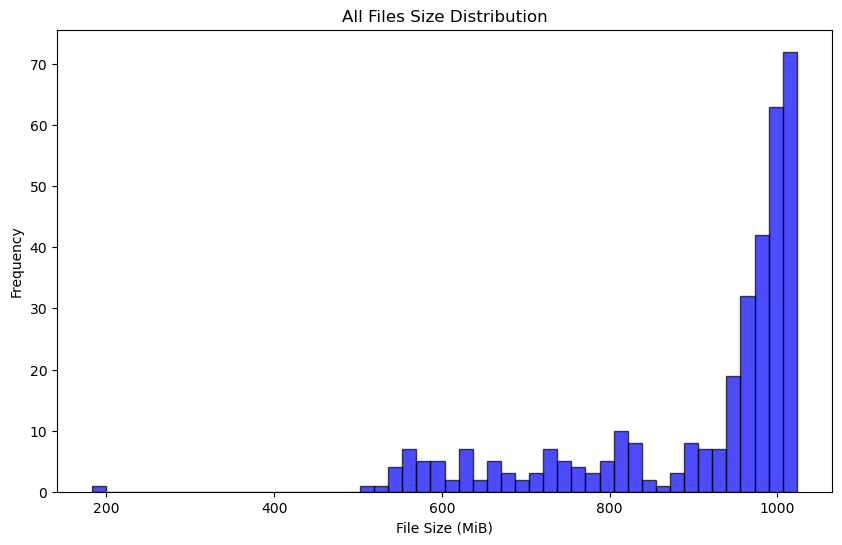

In [83]:
plt.figure(figsize=(10, 6))
plt.hist(df['FILE_SIZE']/1024**2, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('All Files Size Distribution')
plt.xlabel('File Size (MiB)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

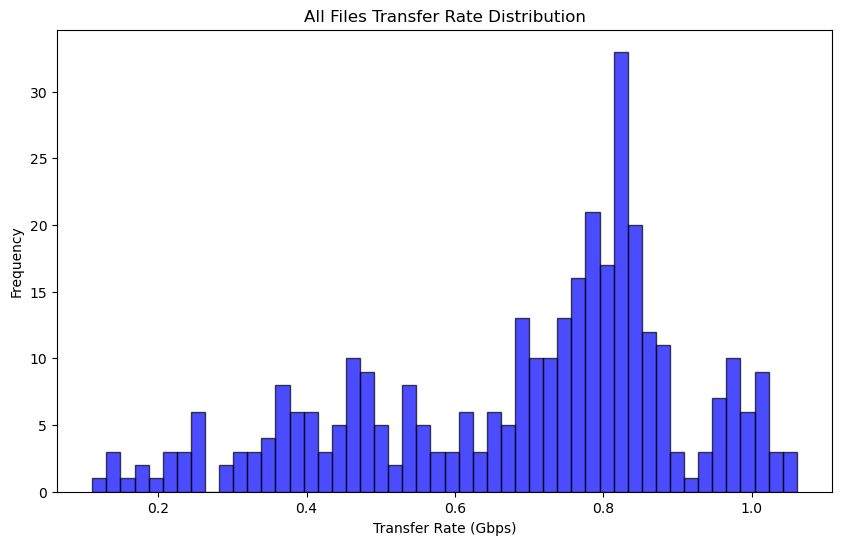

In [84]:
plt.figure(figsize=(10, 6))
plt.hist(df['TRANSFER_RATE'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('All Files Transfer Rate Distribution')
plt.xlabel('Transfer Rate (Gbps)')
plt.ylabel('Frequency')
# plt.xlim(0, 10)
# plt.ylim(0, 200)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

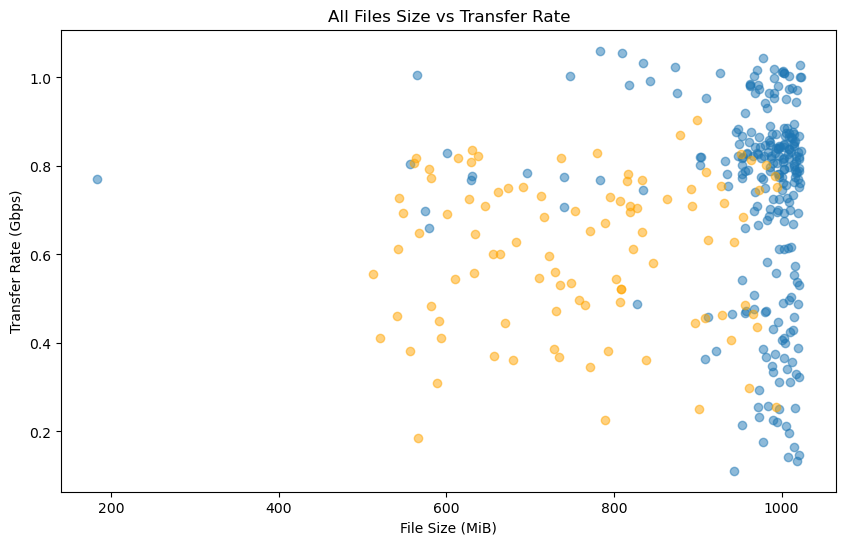

In [85]:
plt.figure(figsize=(10, 6))
plt.scatter(df[df['COMPRESSION_USED']]['FILE_SIZE'] / 1024**2, df[df['COMPRESSION_USED']]['TRANSFER_RATE'], alpha=0.5, colorizer='blue', label='With Compression')
plt.scatter(df[~df['COMPRESSION_USED']]['FILE_SIZE'] / 1024**2, df[~df['COMPRESSION_USED']]['TRANSFER_RATE'], alpha=0.5, color='orange', label='Without Compression')
plt.title('All Files Size vs Transfer Rate')
# plt.xlim(0,3000)
# plt.ylim(0, 15)
plt.xlabel('File Size (MiB)')
plt.ylabel('Transfer Rate (Gbps)')
plt.show()

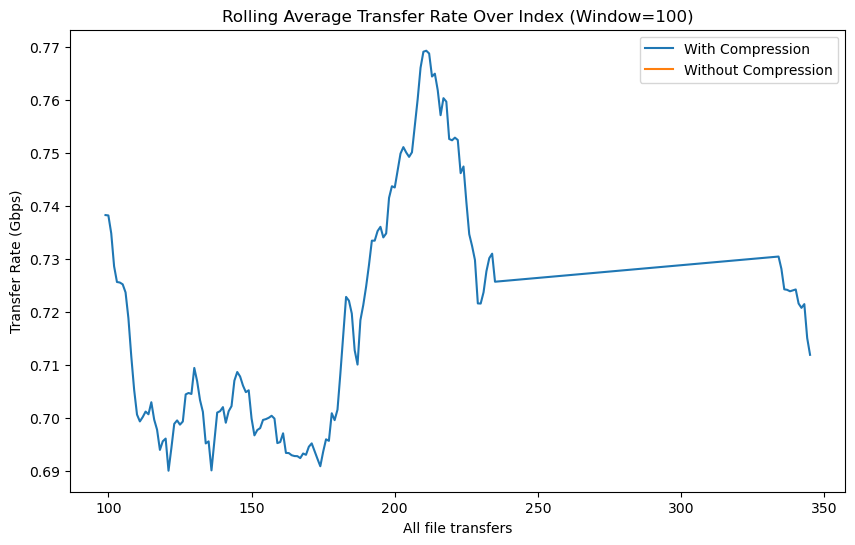

In [86]:
# Calculate the rolling average of the transfer rate over a window of 100
rolling_avg_comp = df[df['COMPRESSION_USED']]['TRANSFER_RATE'].rolling(window=100).mean()
rolling_avg_no_comp = df[~df['COMPRESSION_USED']]['TRANSFER_RATE'].rolling(window=100).mean()

# Plotting the rolling average transfer rate over the index
plt.figure(figsize=(10, 6))
plt.plot(rolling_avg_comp, label='With Compression')
plt.plot(rolling_avg_no_comp, label='Without Compression')
plt.title('Rolling Average Transfer Rate Over Index (Window=100)')
# plt.xlim(0,3000)
# plt.ylim(0, 15)
plt.xlabel('All file transfers')
plt.ylabel('Transfer Rate (Gbps)')
plt.legend()
plt.show()

In [87]:
df[~df['OVERLAP']]

FILE_SIZE                                        BUCKET_NAME  \
0     630387352  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
1     783527151  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
8     821287624  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
11    953448413  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
14   1063581911  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
..          ...                                                ...   
214  1054147122  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
220  1017435545  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
226  1032120660  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
235  1036315556  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   
236   588251136  Somerville-RAL-Transfer-Tests_cirrus_std_Comp_8-2   

     FILES_PER_ZIP  UPLOAD_TIME               UPLOAD_START  \
0                5     5.663316 2025-10-22 21:12:43.037624   
1               10     5.821956 2025-10-22 21:12:49.222554   
8               11     5.769937 2025-10-22 21:13:25.314534   
11              11     7.456225 2025-10-22 21:13:37.494444   
14               8     9.077639 2025-10-22 21:13:53.083032   
..             ...          ...                        ...   
214             38     8.979590 2025-10-22 21:38:59.040401   
220             37     9.140175 2025-10-22 21:39:55.537974   
226             40    29.821977 2025-10-22 21:40:30.990292   
235             36    22.182385 2025-10-22 21:41:44.577485   
236              0     5.426734 2025-10-22 21:42:09.419420   

                    UPLOAD_END  OVERLAP  TYPE  COMPRESSION_USED  TRANSFER_RATE  
0   2025-10-22 21:12:48.700940    False   zip              True       0.829329  
1   2025-10-22 21:12:55.044510    False   zip              True        1.00271  
8   2025-10-22 21:13:31.084471    False   zip              True       1.060509  
11  2025-10-22 21:13:44.950669    False   zip              True       0.952727  
14  2025-10-22 21:14:02.160671    False   zip              True       0.872948  
..                         ...      ...   ...               ...            ...  
214 2025-10-22 21:39:08.019991    False   zip              True       0.874651  
220 2025-10-22 21:40:04.678149    False   zip              True       0.829359  
226 2025-10-22 21:41:00.812269    False   zip              True        0.25786  
235 2025-10-22 21:42:06.759870    False   zip              True       0.348076  
236 2025-10-22 21:42:14.846154    False  file             False       0.807634  

[65 rows x 10 columns]

In [ ]:

client = Client()
print(client.dashboard_link)
df = df.sort_values(by='UPLOAD_START').reset_index(drop=True)
client.scatter(df)
print("sorted df")
print("from pandas df to dask ddf")
ddf = dd.from_pandas(df, npartitions=100)
# --- 1. Data Preparation ---
# Ensure datetime types for accurate calculations
# ddf['UPLOAD_START'] = dd.to_datetime(ddf['UPLOAD_START'])
# ddf['UPLOAD_END'] = dd.to_datetime(ddf['UPLOAD_END'])

# Sort by upload start time to process events chronologically
# --- 2. Create an Event Timeline ---
# Create a list of "events": the start and end of each transfer.
# At each start, the total network rate increases. At each end, it decreases.
def gen_events(row):
    events = []
    if pd.notna(row['TRANSFER_RATE']) and row['TRANSFER_RATE'] > 0:
        events.append({'time': row['UPLOAD_START'], 'rate_change': row['TRANSFER_RATE'], 'compression_used': row['COMPRESSION_USED']})
        events.append({'time': row['UPLOAD_END'], 'rate_change': -row['TRANSFER_RATE'], 'compression_used': row['COMPRESSION_USED']})
    # return pd.DataFrame(events).sort_values(by='time').reset_index(drop=True)
    return events

def process_partition(partition):
    # Apply the function to each row to get a list of lists of dictionaries
    list_of_events = partition.apply(gen_events, axis=1).sum()
    # If no events were generated in this partition, return an empty DataFrame
    if not list_of_events:
        return pd.DataFrame({
            'time': pd.Series(dtype='datetime64[ns]'),
            'rate_change': pd.Series(dtype='float64'),
            'compression_used': pd.Series(dtype='bool')
        })
    # Convert the list of events into a single DataFrame for the partition
    return pd.DataFrame(list_of_events)

events_ddf = ddf.map_partitions(
    process_partition,
    meta={'time': 'datetime64[ns]', 'rate_change': 'float64', 'compression_used': 'bool'}
).dropna().reset_index(drop=True)
print("set up events_ddf")
# Convert the list of events to a DataFrame and sort chronologically
events_df = events_ddf.compute().sort_values(by='time').reset_index(drop=True)
events_df['time'] = pd.to_datetime(events_df['time'])
print("computed events_df")
# --- 3. Calculate Throughput Over Time ---
# Iterate through the timeline, calculating the total data transferred during each interval
# between events. During each interval, the total transfer rate is constant.
total_data_transferred_gb = 0
total_data_transferred_gb_comp = 0
total_data_transferred_gb_no_comp = 0
current_rate_gbps = 0
print("starting loop over events_df")
for i in range(len(events_df) - 1):
    # Update the current total rate with the change from the current event
    current_rate_gbps += events_df.loc[i, 'rate_change']
    
    # Calculate the duration of the current interval (until the next event)
    start_interval = events_df.loc[i, 'time']
    end_interval = events_df.loc[i + 1, 'time']
    duration_seconds = (end_interval - start_interval).total_seconds()
    
    # If there is time between events, calculate data transferred and add to total
    if duration_seconds > 0:
        # Data = Rate (Gbps) * Time (s) -> gives Gigabits
        data_in_interval_gb = current_rate_gbps * duration_seconds
        if events_df.loc[i, 'compression_used']:
            total_data_transferred_gb_comp += data_in_interval_gb
        else:
            total_data_transferred_gb_no_comp += data_in_interval_gb
        total_data_transferred_gb += data_in_interval_gb

# --- 4. Calculate Final Results ---
# Total time from the first upload start to the last upload end
total_duration_seconds = (events_df['time'].max() - events_df['time'].min()).total_seconds()
total_duration_seconds_comp = (events_df[events_df['compression_used']]['time'].max() - events_df[events_df['compression_used']]['time'].min()).total_seconds()
total_duration_seconds_no_comp = (events_df[~events_df['compression_used']]['time'].max() - events_df[~events_df['compression_used']]['time'].min()).total_seconds()

# The overall average network speed is the total data transferred divided by the total time
if total_duration_seconds_comp > 0:
    estimated_total_speed_gbps_comp = total_data_transferred_gb_comp / total_duration_seconds_comp
else:
    estimated_total_speed_gbps_comp = 0
if total_duration_seconds_no_comp > 0:
    estimated_total_speed_gbps_no_comp = total_data_transferred_gb_no_comp / total_duration_seconds_no_comp
else:
    estimated_total_speed_gbps_no_comp = 0
if total_duration_seconds > 0:
    estimated_total_speed_gbps = total_data_transferred_gb / total_duration_seconds
else:
    estimated_total_speed_gbps = 0

print(f"Total duration of all transfers (with compression): {total_duration_seconds_comp:.2f} seconds")
print(f"Total data transferred (with compression, accounting for overlaps): {total_data_transferred_gb_comp / 8:.2f} GiB")
print(f"Estimated average total network speed (with compression): {estimated_total_speed_gbps_comp:.2f} Gbps")
print(f"Total duration of all transfers (without compression): {total_duration_seconds_no_comp:.2f} seconds")
print(f"Total data transferred (without compression, accounting for overlaps): {total_data_transferred_gb_no_comp / 8:.2f} GiB")
print(f"Estimated average total network speed (without compression): {estimated_total_speed_gbps_no_comp:.2f} Gbps")
print(f"Total duration of all transfers (with or without compression): {total_duration_seconds:.2f} seconds")
print(f"Total data transferred (with or without compression, accounting for overlaps): {total_data_transferred_gb / 8:.2f} GiB")
print(f"Estimated average total network speed (with or without compression): {estimated_total_speed_gbps:.2f} Gbps")

/home/dave/miniforge3/envs/lsst-uk/lib/python3.13/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43235 instead
  warnings.warn(


http://127.0.0.1:43235/status
sorted df
from pandas df to dask ddf
set up events_ddf
computed events_df
starting loop over events_df
Total duration of all transfers (with compression): 1971.03 seconds
Total data transferred (with compression, accounting for overlaps): 232.14 GiB
Estimated average total network speed (with compression): 0.94 Gbps
Total duration of all transfers (without compression): 183.32 seconds
Total data transferred (without compression, accounting for overlaps): 73.97 GiB
Estimated average total network speed (without compression): 3.23 Gbps
Total duration of all transfers (with or without compression): 1971.03 seconds
Total data transferred (with or without compression, accounting for overlaps): 306.11 GiB
Estimated average total network speed (with or without compression): 1.24 Gbps


In [89]:
# Verify average
print(f"{(df[df['COMPRESSION_USED']]['UPLOAD_END'].max() - df[df['COMPRESSION_USED']]['UPLOAD_START'].min()).total_seconds():.2f} s, {df[df['COMPRESSION_USED']]['FILE_SIZE'].sum() / (1024**3):.2f} GiB, {df[df['COMPRESSION_USED']]['FILE_SIZE'].sum() * 8 / (1024**3) / ((df[df['COMPRESSION_USED']]['UPLOAD_END'].max() - df[df['COMPRESSION_USED']]['UPLOAD_START'].min()).total_seconds()):.2f} Gbps")
print(f"{(df[~df['COMPRESSION_USED']]['UPLOAD_END'].max() - df[~df['COMPRESSION_USED']]['UPLOAD_START'].min()).total_seconds():.2f} s, {df[~df['COMPRESSION_USED']]['FILE_SIZE'].sum() / (1024**3):.2f} GiB, {df[~df['COMPRESSION_USED']]['FILE_SIZE'].sum() * 8 / (1024**3) / ((df[~df['COMPRESSION_USED']]['UPLOAD_END'].max() - df[~df['COMPRESSION_USED']]['UPLOAD_START'].min()).total_seconds()):.2f} Gbps")
print(f"{(df['UPLOAD_END'].max() - df['UPLOAD_START'].min()).total_seconds():.2f} s, {df['FILE_SIZE'].sum() / (1024**3):.2f} GiB, {df['FILE_SIZE'].sum() * 8 / (1024**3) / ((df['UPLOAD_END'].max() - df['UPLOAD_START'].min()).total_seconds()):.2f} Gbps")

1971.03 s, 232.66 GiB, 0.94 Gbps
183.32 s, 73.44 GiB, 3.21 Gbps
1971.03 s, 306.11 GiB, 1.24 Gbps


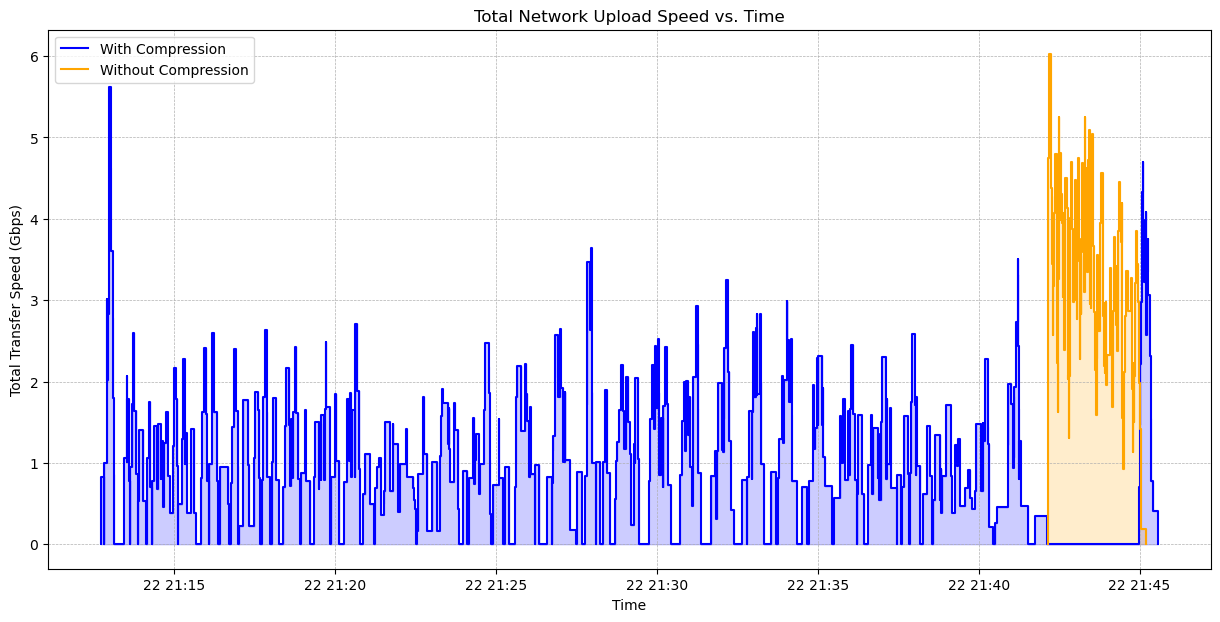

In [90]:
# --- 5. Plot Total Throughput Over Time by Compression ---

# Helper function to generate step plot data from an events dataframe
def prepare_step_plot_data(df):
    if df.empty:
        return [], []
    
    # Calculate the cumulative sum of rate changes to get the total network speed
    df['total_rate'] = df['rate_change'].cumsum()
    
    # Prepare data for a step plot
    times = []
    rates = []
    
    # Start the plot at a rate of 0 just before the first event
    times.append(df['time'].iloc[0])
    rates.append(0)
    
    for i in range(len(df) - 1):
        # Point at the beginning of the interval with the new rate
        times.append(df['time'].iloc[i])
        rates.append(df['total_rate'].iloc[i])
        # Point at the end of the interval with the same rate (creates the horizontal step)
        times.append(df['time'].iloc[i+1])
        rates.append(df['total_rate'].iloc[i])
        
    # Add the final point
    times.append(df['time'].iloc[-1])
    rates.append(df['total_rate'].iloc[-1])
    
    return times, rates

# Separate events by compression
comp_events_df = events_df[events_df['compression_used']].copy().reset_index(drop=True)
nocomp_events_df = events_df[~events_df['compression_used']].copy().reset_index(drop=True)

# Generate plot data for each case
comp_plot_times, comp_plot_rates = prepare_step_plot_data(comp_events_df)
nocomp_plot_times, nocomp_plot_rates = prepare_step_plot_data(nocomp_events_df)

# --- Plotting the data ---
plt.figure(figsize=(15, 7))

# Plot for "With Compression"
if comp_plot_times:
    plt.plot(comp_plot_times, comp_plot_rates, label='With Compression', color='blue')
    plt.fill_between(comp_plot_times, comp_plot_rates, alpha=0.2, color='blue')

# Plot for "Without Compression"
if nocomp_plot_times:
    plt.plot(nocomp_plot_times, nocomp_plot_rates, label='Without Compression', color='orange')
    plt.fill_between(nocomp_plot_times, nocomp_plot_rates, alpha=0.2, color='orange')

plt.title('Total Network Upload Speed vs. Time')
plt.xlabel('Time')
plt.ylabel('Total Transfer Speed (Gbps)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [91]:
events_df

time  rate_change  compression_used
0   2025-10-22 21:12:43.037624     0.829329              True
1   2025-10-22 21:12:48.700940    -0.829329              True
2   2025-10-22 21:12:49.222554     1.002710              True
3   2025-10-22 21:12:54.293436     0.991434              True
4   2025-10-22 21:12:54.891007     1.023257              True
..                         ...          ...               ...
687 2025-10-22 21:45:19.057591    -0.745684              True
688 2025-10-22 21:45:21.097304    -0.767943              True
689 2025-10-22 21:45:21.551764    -0.772009              True
690 2025-10-22 21:45:25.343329    -0.364201              True
691 2025-10-22 21:45:34.065913    -0.407535              True

[692 rows x 3 columns]

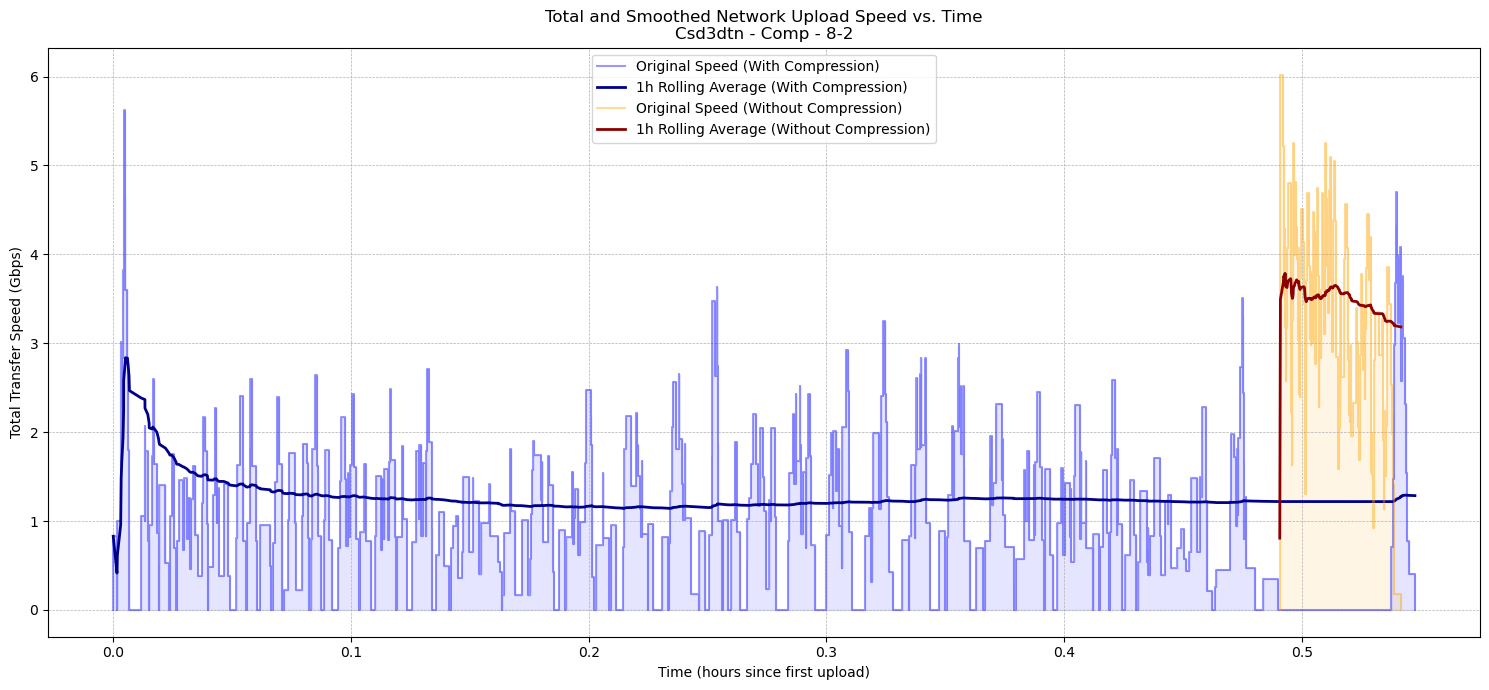

In [92]:
# --- 6. Plot Smoothed Throughput Over Time by Compression ---
import os

all_comp = False


# To perform a time-based rolling average, we first set the 'time' column as the index for each dataset.
# The dataframes comp_events_df and nocomp_events_df were created in the previous cell.
comp_events_indexed_by_time = comp_events_df.set_index('time')
if not all_comp:
    nocomp_events_indexed_by_time = nocomp_events_df.set_index('time')

# Calculate the cumulative sum of rate changes to get the total network speed
comp_events_indexed_by_time['total_rate'] = comp_events_indexed_by_time['rate_change'].cumsum()
if not all_comp:
    nocomp_events_indexed_by_time['total_rate'] = nocomp_events_indexed_by_time['rate_change'].cumsum()

# Calculate the rolling mean over a 1-hour window for both datasets.
smoothed_rate_comp = comp_events_indexed_by_time['total_rate'].rolling('1h').mean()
if not all_comp:
    smoothed_rate_nocomp = nocomp_events_indexed_by_time['total_rate'].rolling('1h').mean()

# --- Convert x-axis from datetime to elapsed seconds for all plots ---
# Get the global start time of the first event
start_time = events_df['time'].min()

# Convert the datetime values for the original step plots to elapsed seconds
comp_plot_times_hours = [(t - start_time).total_seconds()/3600 for t in comp_plot_times]
if not all_comp:
    nocomp_plot_times_hours = [(t - start_time).total_seconds()/3600 for t in nocomp_plot_times]

# Convert the datetime index of the smoothed data to elapsed seconds
smoothed_times_comp_hours = (smoothed_rate_comp.index - start_time).total_seconds() / 3600
if not all_comp:
    smoothed_times_nocomp_hours = (smoothed_rate_nocomp.index - start_time).total_seconds() / 3600

# --- Plotting the original and smoothed data together ---
plt.figure(figsize=(15, 7))

# Plot for "With Compression"
if comp_plot_times:
    # Plot the original, "spiky" step plot
    plt.plot(comp_plot_times_hours, comp_plot_rates, label='Original Speed (With Compression)', alpha=0.4, color='blue')
    plt.fill_between(comp_plot_times_hours, comp_plot_rates, alpha=0.1, color='blue')
    # Plot the smoothed data
    plt.plot(smoothed_times_comp_hours, smoothed_rate_comp.values, label='1h Rolling Average (With Compression)', color='darkblue', linewidth=2)

# Plot for "Without Compression"
if nocomp_plot_times:
    # Plot the original, "spiky" step plot
    plt.plot(nocomp_plot_times_hours, nocomp_plot_rates, label='Original Speed (Without Compression)', alpha=0.4, color='orange')
    plt.fill_between(nocomp_plot_times_hours, nocomp_plot_rates, alpha=0.1, color='orange')
    # Plot the smoothed data
    plt.plot(smoothed_times_nocomp_hours, smoothed_rate_nocomp.values, label='1h Rolling Average (Without Compression)', color='darkred', linewidth=2)


plt.title(f'Total and Smoothed Network Upload Speed vs. Time\n{platform.capitalize()} - {compression} - {workers}-{threads}')
plt.xlabel('Time (hours since first upload)')
plt.ylabel('Total Transfer Speed (Gbps)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.savefig(os.path.expanduser(f'{this_base_path}/total_and_smoothed_network_upload_speed_{platform}_{compression}_{workers}-{threads}.png'))
plt.show()

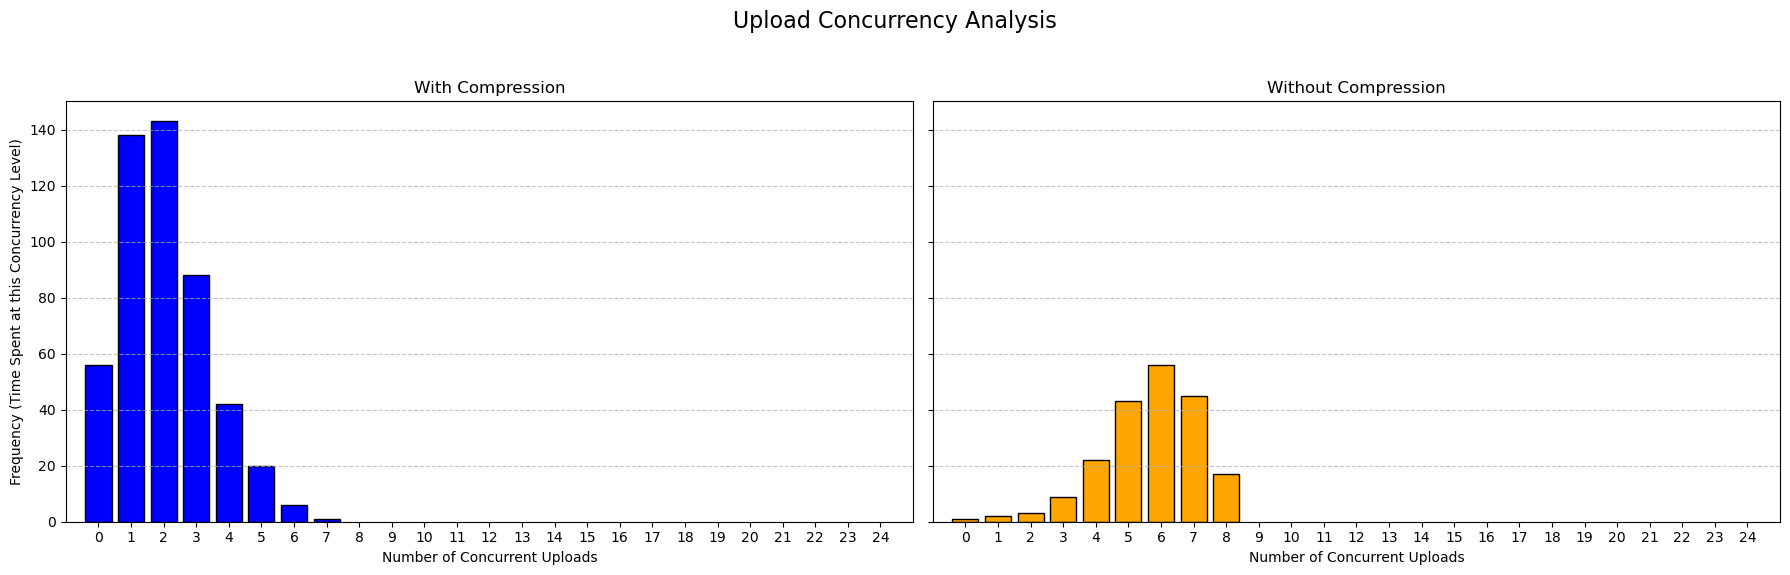

In [93]:
# --- 7. Analyze and Plot Upload Concurrency by Compression ---

# Create a figure with two subplots, sharing the Y-axis for easier comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fig.suptitle('Upload Concurrency Analysis', fontsize=16)

# --- Plot for "With Compression" ---
comp_events_df = events_df[events_df['compression_used'] == True].copy()
if not comp_events_df.empty:
    # Determine the change in concurrency at each event (+1 for start, -1 for end)
    comp_events_df['concurrency_change'] = comp_events_df['rate_change'].apply(lambda x: 1 if x > 0 else -1)
    # Calculate the cumulative sum to find the number of concurrent uploads at any given time
    comp_events_df['concurrency'] = comp_events_df['concurrency_change'].cumsum()

    # Plot a histogram of the concurrency counts
    max_concurrency_comp = int(comp_events_df['concurrency'].max())
    axes[0].hist(comp_events_df['concurrency'], bins=range(0, max_concurrency_comp + 2), align='left', rwidth=0.8, edgecolor='black', color='blue')
    axes[0].set_title('With Compression')
    axes[0].set_xlabel('Number of Concurrent Uploads')
    axes[0].set_ylabel('Frequency (Time Spent at this Concurrency Level)')
    axes[0].set_xlim(-1, 25)
    axes[0].set_xticks(np.arange(0, 25))
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Plot for "Without Compression" ---
nocomp_events_df = events_df[events_df['compression_used'] == False].copy()
if not nocomp_events_df.empty:
    # Determine the change in concurrency at each event (+1 for start, -1 for end)
    nocomp_events_df['concurrency_change'] = nocomp_events_df['rate_change'].apply(lambda x: 1 if x > 0 else -1)
    # Calculate the cumulative sum to find the number of concurrent uploads at any given time
    nocomp_events_df['concurrency'] = nocomp_events_df['concurrency_change'].cumsum()

    # Plot a histogram of the concurrency counts
    max_concurrency_nocomp = int(nocomp_events_df['concurrency'].max())
    axes[1].hist(nocomp_events_df['concurrency'], bins=range(0, max_concurrency_nocomp + 2), align='left', rwidth=0.8, edgecolor='black', color='orange')
    axes[1].set_title('Without Compression')
    axes[1].set_xlabel('Number of Concurrent Uploads')
    axes[1].set_xlim(-1, 25)
    axes[1].set_xticks(np.arange(0, 25))
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.savefig(os.path.expanduser(f'{this_base_path}/upload_concurrency_{platform}_{compression}_{workers}-{threads}.png'))

In [94]:
events_df

time  rate_change  compression_used
0   2025-10-22 21:12:43.037624     0.829329              True
1   2025-10-22 21:12:48.700940    -0.829329              True
2   2025-10-22 21:12:49.222554     1.002710              True
3   2025-10-22 21:12:54.293436     0.991434              True
4   2025-10-22 21:12:54.891007     1.023257              True
..                         ...          ...               ...
687 2025-10-22 21:45:19.057591    -0.745684              True
688 2025-10-22 21:45:21.097304    -0.767943              True
689 2025-10-22 21:45:21.551764    -0.772009              True
690 2025-10-22 21:45:25.343329    -0.364201              True
691 2025-10-22 21:45:34.065913    -0.407535              True

[692 rows x 3 columns]